# Introduction 

Suppose you own a fish tank and you are wondering about the rate at which you should keep adding food to the tank. You observe that at any given time $t$, the proportion of food left in the tank is $

In [1]:
using LinearAlgebra
using PyPlot

# Nyström's method for Fredholm equations of the second kind

Suppose we would like to solve the following integral equation: 

$$ f(t) = \lambda\int_{a}^{b}K(s,t)f(s)\,ds + g(t)$$

Then one approach to finding $f$ is by applying a quadrature rule on the integral. Sampling at the points $t_i$ we get that 

$$ f(t_i) \approx \lambda\sum_{j=1}^{N}w_j K(t_i,s_j)f(s_j) + g(t_i)$$

We may interpret the summation as a matrix multiplication: 

$$ \sum_{j=1}^{N}w_j K(t_i,s_j)f(s_j) = \begin{bmatrix} w_1K(t_1,s_1) & \ldots & w_NK(t_1,s_N) \\ \vdots & \ddots & \vdots \\ w_1K(t_n,s_1) & \ldots & w_NK(t_n,s_N)\end{bmatrix}\begin{bmatrix}f(s_1) \\ \vdots \\ f(s_n) \end{bmatrix} = \textbf{K}\textbf{f}$$

As a result we have the matrix equation 

$$ \textbf{f} = \lambda\textbf{K}\textbf{f} + \textbf{g} $$

We can rearrange it to get 

$$ (I - \lambda\textbf{K})\textbf{f} = \textbf{g} $$

Solving for $\textbf{f}$ yields the values of $f$ at the sample points. But just because we know $f$ at finitely many points does not mean we know it everywhere on the interval. We still need to interpolate $f$ using some known functions. Nyström's insight was that we don't need to construct an interpolation: we already have it fr
om the quadrature rule. 

$$ f(t) = \lambda\sum_{j=1}^{N}w_j K(t,s_j)f(s_j) + g(t)$$

In the following example, I implement Nyström's method using two quadrature rules: Simpson's rule and Gauss-Legendre quadrature. Suppose the given integral equation is 

$$ f(x) = e^{-x} - \frac{1}{2} + \frac{1}{2}e^{-(x+1)} + \frac{1}{2}\int_{0}^{1}(x+1)e^{-xy}f(y)\,dy$$

Recall that the composite Simpson's rule is given as 

$$ I_N = \frac{1}{3}\Big(hf(a) + 2h\sum_{n=1}^{N-1}f(a + 2nh) + 4h\sum_{n=1}^{N}f(a + (2n-1)h) + hf(b)\Big)$$

In [70]:
function simpson_matrix(N,a,b,K,samples)

    S = zeros(2*N + 1, 2*N + 1)
    h = (b-a)/(2*N)
    for i in 1:2*N + 1
            if i == 1
            S[i,i] = (1/3)*h
            elseif i == 2*N + 1
            S[i,i] = (1/3)*h
            elseif i%2 == 0
            S[i,i] = (1/3)*4*h
            else 
            S[i,i] = (1/3)*2*h
        end
    
    end
    
    Kmatrix = zeros(2*N + 1, 2*N + 1)
    for i in 1:2*N + 1 
        for j in 1:2*N + 1
            Kmatrix[i,j] = K(samples[i],samples[j])
        end
    end


    
    return Kmatrix*S
end

simpson_matrix (generic function with 1 method)

In [71]:
function solution(t,weights,F,K,g,samples,λ)
    sols = 0.0
    for i in 1:size(F)[1]
        sols = sols + weights[i]*K(t,samples[i])*F[i]
    end
    return λ*sols + g(t)
end

solution (generic function with 1 method)

In [84]:
K(x,y) = (x+1)*exp(-x*y)
g(x) = exp(-x) - (1/2) + (1/2)*exp(-(x+1))

N = 10
samples = LinRange(0,1,2*N + 1)
λ = (1/2)
a = 0 
b = 1
G = g.(samples)
Kmat = simpson_matrix(N,0,1,K,samples) #compute matrix
Id = zeros(2*N + 1, 2*N + 1) + I
M = (Id - λ*Kmat)
F = M \ G

S = zeros(2*N + 1, 2*N + 1)
    h = (b-a)/(2*N)
    for i in 1:2*N + 1
            if i == 1
            S[i,i] = (1/3)*h
            elseif i == 2*N + 1
            S[i,i] = (1/3)*h
            elseif i%2 == 0
            S[i,i] = (1/3)*4*h
            else 
            S[i,i] = (1/3)*2*h
        end
    
    end

weights = zeros(2*N + 1)
for i in 1:size(weights)[1]
   weights[i] = S[i,i]
end

s(t) = solution(t,weights,F,K,g,samples,λ)
#zeros(2*10 + 1, 2*10 + 1)

s (generic function with 1 method)

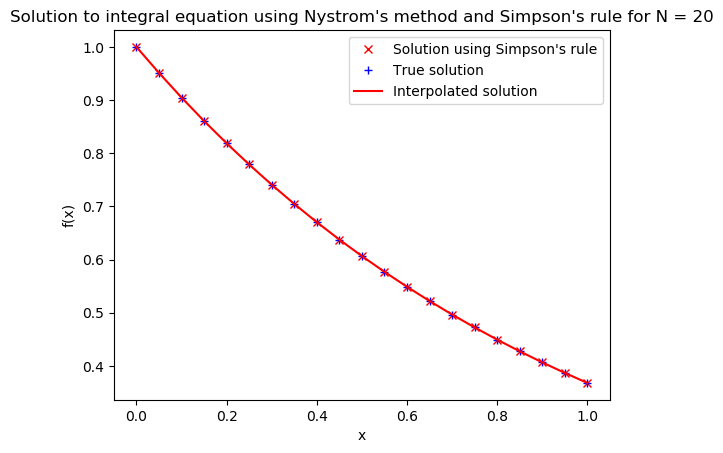

In [85]:
figure()

plot(samples, F, "rx", label="Solution using Simpson's rule")
plot(samples, exp.((-1).*samples), "b+", label="True solution")
plot(samples, s.(samples), "r-", label="Interpolated solution")
legend()
xlabel("x")
ylabel("f(x)")
title("Solution to integral equation using Nystrom's method and Simpson's rule for N = 20");

In [44]:
function legendre(n)
    """ Use explicit formula to evaluate Legendre Polynomial P_n
    """
    function Pn(x)
        f = 0.0
        for k=0:n
            f += 2.0^(-n) * binomial(n, k)^2 * (x - 1)^(n - k) * (x + 1)^k
        end
        return f
    end
end

function weights_matrix(N, x)
    """ Construct the matrix B with entries
    B_{ij} = Q_i(x_j)
    """
    Q = [legendre(n) for n=0:N-1]
    
    [Q[i](x[j]) for i=1:length(Q), j=1:length(x)]
end

α(n) = n/(2n+1)
β(n) = 0
γ(n) = (n+1)/(2n+1)

# construct matrix
A(N) = diagm(   0 => β.(0:N-1),
             1 => γ.(0:N-2),
            -1 => α.(1:N-1))


# weight matrix for Gaussian samples
function Gaussian_weights(N)
    
    A_N = A(N)
xn = eigvals(A_N) # roots of Q_N(x)

W = weights_matrix(N, xn)

# rhs
b = zeros(N)
b[1] = 2.0 # from orthogonality

# find quadrature weights
w = W \ b

return w
end

Gaussian_matrix (generic function with 2 methods)

In [102]:
N = 50
A_N = A(N)
xn = eigvals(A_N) # roots of Q_N(x)

W = weights_matrix(N, xn)

50×50 Array{Float64,2}:
  1.0         1.0         1.0        …   1.0         1.0         1.0      
 -0.998866   -0.994032   -0.985354       0.557158    0.449806    0.504458 
  0.996601    0.982149    0.956384      -0.0343619  -0.196511   -0.118283 
 -0.993208   -0.964458   -0.913725      -0.403347   -0.447191   -0.435753 
  0.988693    0.941117    0.858312      -0.367503   -0.204628   -0.295972 
 -0.983063   -0.912335   -0.791355   …  -0.0458855   0.192076    0.0798532
  0.976329    0.878367    0.714308       0.259383    0.328917    0.320494 
 -0.968501   -0.839516   -0.628839       0.307719    0.110126    0.23181  
  0.959594    0.796128    0.536785       0.094506   -0.194924   -0.0611731
 -0.949621   -0.748585   -0.440109      -0.174069   -0.263504   -0.264343 
  0.9386      0.697309    0.340854   …  -0.269325   -0.0497676  -0.198309 
 -0.92655    -0.642749   -0.241092      -0.128227    0.196812    0.0493289
  0.913491    0.585384    0.142876       0.109949    0.215298    0.229478 
 

In [68]:
K(x,y) = (x+1)*exp(-x*y)
g(x) = exp(-x) - (1/2) + (1/2)*exp(-(x+1))

N1 = 40
A_N = A(N1)
samples1 = eigvals(A_N)
Kprime(t,u) = K(t,(u+1)/2)


function Gaussian_matrix(N,K,samples)
# this is only for the interval [0,1]
   S = diagm( 0 => Gaussian_weights(N))
    
    Kmatrix = zeros(N, N)
    for i in 1:N
        for j in 1:N
            Kmatrix[i,j] = K((samples[i].+ 1)./2,samples[j])
        end
    end

    return Kmatrix*S
    
end




λ1 = (1/2)
G1 = g.((samples1 .+ 1)./2)

Gmat = Gaussian_matrix(N1,Kprime,samples1)
Id = zeros(N1,N1) + I
M1 = Id - (λ1 / 2)*Gmat
F1 = M1 \ G1

#s2(t) = solution(t,Gaussian_weights(N1),F1,Kprime,g,samples1,λ1)
#zeros(2*10 + 1, 2*10 + 1)


function sols(t,weights,F,Kprime,g,samples,λ)
    sum = 0.0
    for i in 1:size(F)[1]
        sum = sum + weights[i]*Kprime(t,samples[i])*F[i]
    end
    return (λ/2)*sum + g(t)
end

s2(t) = solution(t, Gaussian_weights(N1), F1, Kprime, g, samples1, λ1)


s2 (generic function with 1 method)

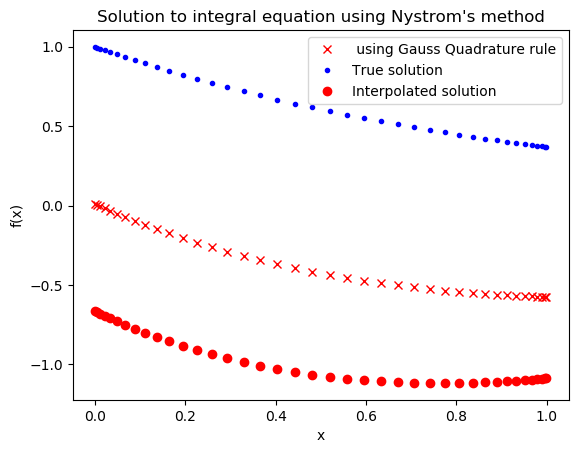

In [75]:
plot((samples1 .+ 1)./2, F1, "rx", label=" using Gauss Quadrature rule")
plot((samples1 .+ 1)./2, exp.((-1).*(samples1 .+ 1)./2), "b.", label="True solution")
plot((samples1 .+ 1)./2, s2.((samples1 .+ 1)./2), "ro", label="Interpolated solution")
legend()
xlabel("x")
ylabel("f(x)")
title("Solution to integral equation using Nystrom's method");

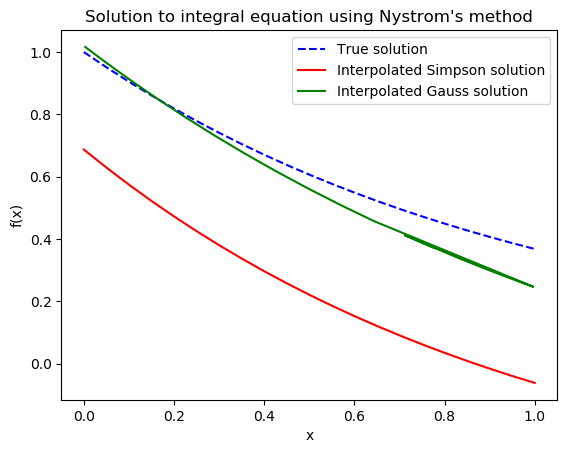

In [134]:
figure()

#plot(times, F, "rx", label="Solution using Simpson's rule")
plot(times, exp.((-1).*times), "b--", label="True solution")
plot(times, s.(times), "r-", label="Interpolated Simpson solution")
#plot((times1 .+ 1)./2, F1, "gx", label="Solution using Gauss Quadrature rule")
#plot((times1 .+ 1)./2, exp.((-1).*(times1 .+ 1)./2), "b.", label="True solution")
plot((times1 .+ 1)./2, s2.((times1 .+ 1)./2), "g-", label="Interpolated Gauss solution")
legend()
xlabel("x")
ylabel("f(x)")
title("Solution to integral equation using Nystrom's method");

In [86]:
K(x,y) = (x+1)*exp(-x*y)
g(x) = exp(-x) - (1/2) + (1/2)*exp(-(x+1))
Kprime(t,u) = K(t,(u+1)/2)
λ = (1/2)
N = 10
A_N = A(N)
Gsamples = eigvals(A_N)
Gweights = Gaussian_weights(N)
GaussMatrix = zeros(N,N)
for i in 1:N
    for j in 1:N
        GaussMatrix[i,j] = Kprime((Gsamples[i] + 1)*(0.5),Gsamples)
    end
end

WeightMatrix = diagm( 0 => Gweights)

Id = zeros(N,N) + I

Solver = Id - (λ/2)*GaussMatrix*WeightMatrix

Points = Solver \ g.((Gsamples .+ 1)./2)

MethodError: MethodError: no method matching +(::Array{Float64,1}, ::Int64)
Closest candidates are:
  +(::Any, ::Any, !Matched::Any, !Matched::Any...) at operators.jl:502
  +(!Matched::Complex{Bool}, ::Real) at complex.jl:292
  +(!Matched::Missing, ::Number) at missing.jl:97
  ...

In [101]:
K(x,y) = (x+1)*exp(-x*y)
g(x) = exp(-x) - (1/2) + (1/2)*exp(-(x+1))
Kprime(t,u) = K(t,(u+1)/2)
λ = (1/2)
N = 50
A_N = A(N)
Gsamples = eigvals(A_N)
Gweights = Gaussian_weights(N)
GaussMatrix = zeros(N,N)
for i in 1:N
    for j in 1:N
        GaussMatrix[i,j] = Kprime((Gsamples[i] + 1)*(0.5),Gsamples[j])
    end
end

#WeightMatrix = diagm( 0 => Gweights)

Id = zeros(N,N) + I

#Solver = Id - (λ/2)*GaussMatrix*WeightMatrix



#Points = Solver \ g.((Gsamples .+ 1)./2)

[-4.65116e9, 1.54564e10, -2.76111e10, 3.81963e10, -4.51409e10, 4.73649e10, -4.48507e10, 3.85115e10, -2.98745e10, 2.06626e10, -1.23852e10, 6.03836e9, -1.97966e9, -1.2841e7, 5.40545e8, -3.22254e8, -4.18789e7, 2.1251e8, -1.31399e8, -6.29195e7, 1.72613e8, -6.78438e7, -2.46258e8, 6.41728e8, -9.41953e8, 1.01522e9, -8.39739e8, 5.086e8, -1.73529e8, -4.33017e7, 1.22814e8, -1.65491e8, 4.54086e9, -1.50852e10, 2.6932e10, -3.72209e10, 4.39233e10, -4.59834e10, 4.33891e10, -3.70419e10, 2.84458e10, -1.92971e10, 1.10832e10, -4.78894e9, 7.74932e8, 1.16604e9, -1.61462e9, 1.2713e9, 3.32539e8, -7.28306e8]